In [2]:
import numpy as np
import cv2
import math
from itertools import product

import skimage as sk
import skimage.io as skio
import skimage.data as data
import skimage.transform as sktr
from skimage.color import rgb2gray
from skimage.draw import polygon

import scipy.signal as signal
from scipy.spatial import Delaunay
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get_points(im1, im2, num_pts):
    print('Please select {} points in each image for alignment.', num_pts)
    plt.imshow(im1)
    pts1 = np.array(plt.ginput(num_pts, timeout=0))
    plt.close()
    plt.imshow(im2)
    pts2 = np.array(plt.ginput(num_pts, timeout=0))
    plt.close()
    return pts1, pts2

In [4]:
im1 = plt.imread('data/george_small.jpg')
im2 = plt.imread('data/me.jpg')
im_shape = (750, 600)
im1 = sktr.resize(im1, im_shape)
im2 = sktr.resize(im2, im_shape)
%matplotlib qt
pts1_orig, pts2_orig = get_points(im1, im2, 55)

Please select {} points in each image for alignment. 55


In [5]:
np.save('pts1_orig.npy', pts1_orig)
np.save('pts2_orig.npy', pts1_orig)

In [6]:
# pts xy are inverse from numpy arrays
pts1 = np.vstack([pts1_orig, np.array([[0, 0], [im_shape[1]-1, 0], [0, im_shape[0]-1], [im_shape[1]-1, im_shape[0]-1]])])
pts2 = np.vstack([pts2_orig, np.array([[0, 0], [im_shape[1]-1, 0], [0, im_shape[0]-1], [im_shape[1]-1, im_shape[0]-1]])])

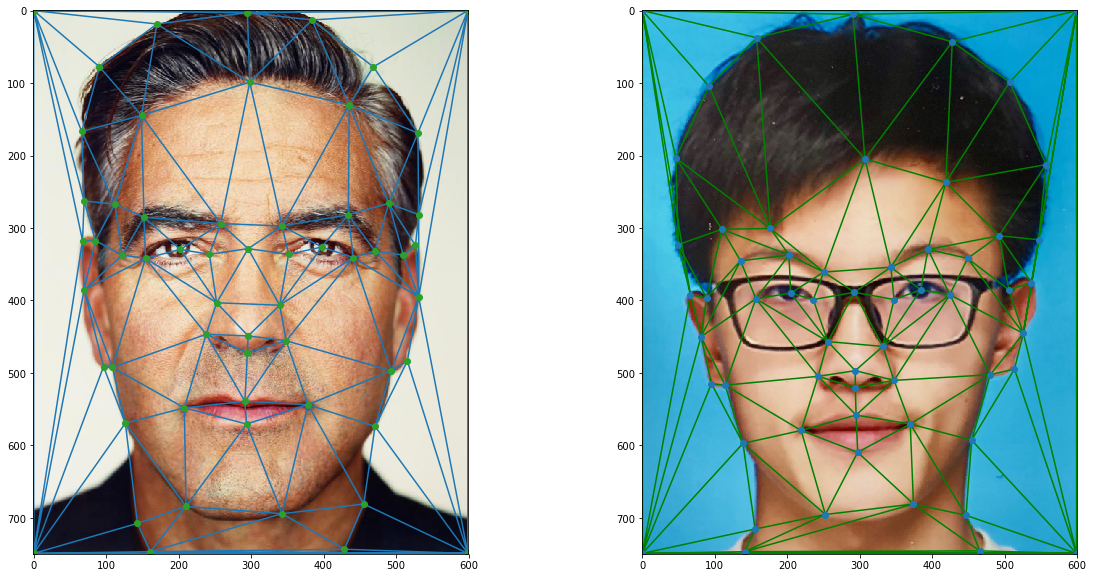

In [13]:
%matplotlib inline
tri = Delaunay(pts1)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(im1)
plt.triplot(pts1[:,0], pts1[:,1], tri.simplices)
plt.plot(pts1[:,0], pts1[:,1], 'o')

plt.subplot(1, 2, 2)
plt.imshow(im2)
plt.triplot(pts2[:,0], pts2[:,1], tri.simplices, color='g')
plt.plot(pts2[:,0], pts2[:,1], 'o')

In [17]:
def computeAffine(tri1_pts, tri2_pts):
    # points are in the same order shape(3, 2)
    v1 = np.reshape((tri1_pts[1] - tri1_pts[0]), (2, 1))
    v2 = np.reshape((tri1_pts[2] - tri1_pts[0]), (2, 1))
    mat1 = np.hstack([v1, v2, np.resize(tri1_pts[0], (2, 1))])
    mat1 = np.vstack([mat1, np.array([[0, 0, 1]])])
    mat1 = np.linalg.inv(mat1)
    u1 = np.reshape(tri2_pts[1] - tri2_pts[0], (2, 1))
    u2 = np.reshape(tri2_pts[2] - tri2_pts[0], (2, 1))
    mat2 = np.hstack([u1, u2, np.resize(tri2_pts[0], (2, 1))])
    mat2 = np.vstack([mat2, np.array([[0, 0, 1]])])
    mat_T = np.dot(mat2, mat1)
    return mat_T

In [18]:
# mid-way face
mid_pts = (pts1 + pts2) / 2
mask1 = np.zeros((im_shape[0], im_shape[1], 3))
mask2 = np.zeros((im_shape[0], im_shape[1], 3))
for tri_index in tri.simplices:
    src1_tri = pts1[tri_index]
    src2_tri = pts2[tri_index]
    mid_tri = mid_pts[tri_index]
    
    mat_T1 = computeAffine(src1_tri, mid_tri)
    mat_T2 = computeAffine(src2_tri, mid_tri)
    
    rr, cc = polygon(mid_tri[:, 0], mid_tri[:, 1])
    mid_xys = np.array([rr, cc])
    
    src1_xys = np.dot(np.linalg.inv(mat_T1), np.vstack([mid_xys, np.ones((1, mid_xys.shape[1]))])).astype(int)
    src2_xys = np.dot(np.linalg.inv(mat_T2), np.vstack([mid_xys, np.ones((1, mid_xys.shape[1]))])).astype(int)
    # todo use interpolation
    mask1[mid_xys[1], mid_xys[0]] = im1[src1_xys[1], src1_xys[0]]
    mask2[mid_xys[1], mid_xys[0]] = im2[src2_xys[1], src2_xys[0]]

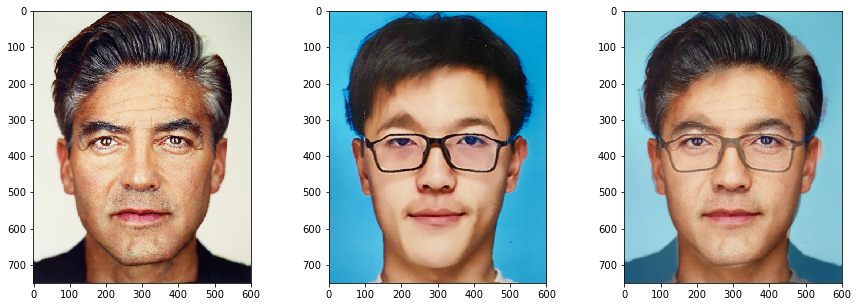

In [19]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(mask1)
plt.subplot(1, 3, 2)
plt.imshow(mask2)
plt.subplot(1, 3, 3)
mid_img = (mask1+mask2)/2
plt.imshow(mid_img)

In [20]:
def morph(im1, im2, pts1, pts2, tri, warp_frac, dissolve_frac):
    assert 0<=warp_frac<=1 and 0<=dissolve_frac<=1
    assert im1.shape == im2.shape
    mid_pts = warp_frac*pts1 + (1-warp_frac)*pts2
    mask1 = np.zeros((im1.shape[0], im1.shape[1], 3))
    mask2 = np.zeros((im2.shape[0], im2.shape[1], 3))
    for tri_index in tri.simplices:
        src1_tri = pts1[tri_index]
        src2_tri = pts2[tri_index]
        mid_tri = mid_pts[tri_index]
        
        # todo swap order so as not to compuute inverse
        mat_T1 = computeAffine(src1_tri, mid_tri)
        mat_T2 = computeAffine(src2_tri, mid_tri)

        rr, cc = polygon(mid_tri[:, 0], mid_tri[:, 1])
        mid_xys = np.array([rr, cc])

        src1_xys = np.dot(np.linalg.inv(mat_T1), np.vstack([mid_xys, np.ones((1, mid_xys.shape[1]))])).astype(int)
        src2_xys = np.dot(np.linalg.inv(mat_T2), np.vstack([mid_xys, np.ones((1, mid_xys.shape[1]))])).astype(int)
        # todo use interpolation
        mask1[mid_xys[1], mid_xys[0]] = im1[src1_xys[1], src1_xys[0]]
        mask2[mid_xys[1], mid_xys[0]] = im2[src2_xys[1], src2_xys[0]]
        morphed_im = dissolve_frac*mask1 + (1-dissolve_frac)*mask2
    return morphed_im

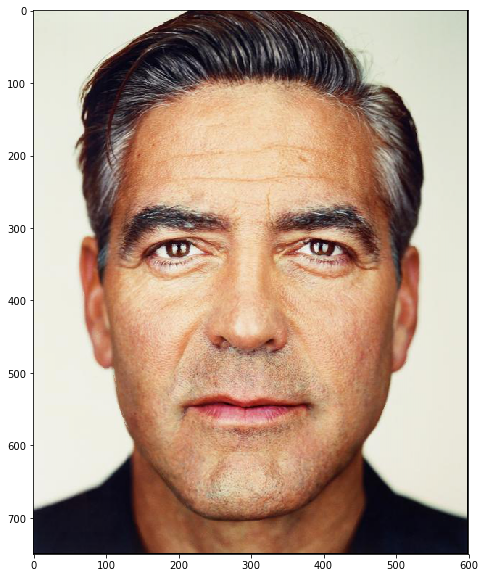

In [23]:
fig = plt.figure(figsize=(8, 10))

ims = []
total_frames = 45
for frac in np.linspace(0, 1, total_frames):
    morphed_im = morph(im1, im2, pts1, pts2, tri, frac, frac)
    im = plt.imshow(morphed_im, animated=True)
    ims.append([im])


In [22]:
anim = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                 repeat_delay=1000)
anim.save('morph_slow.gif', writer='imagemagick', fps=10)

NameError: name 'fig' is not defined